This notebook is desined for tabular classification tasks with pandas and scikit-learn.
It is a simple example of how to use pandas and scikit-learn to build a classification model using a tabular dataset. The code includes data preprocessing, model training, and evaluation steps.
The dataset used in this example is the bank marketing dataset from the UCI Machine Learning Repository. The dataset contains information about a bank's marketing campaign and whether or not a customer subscribed to a term deposit.
The goal is to predict whether a customer will subscribe to a term deposit based on their demographic and behavioral features.


In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
data=pd.read_csv('/home/tisinr/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [4]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types for faster loading
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

In [5]:
data['poutcome'].value_counts(dropna=False)/len(data)*100

poutcome
unknown    81.747805
failure    10.840282
other       4.069806
success     3.342107
Name: count, dtype: float64

In [6]:
# Drop poutcome with more than 80% unknown values
data.drop('poutcome', axis=1, inplace=True)


In [7]:
data.isnull().sum()

age               0
job               0
marital_status    0
education         0
credit_default    0
balance           0
housing_loan      0
personal_loan     0
contact           0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
response          0
dtype: int64

Determine if data is imbalance

In [8]:
data['response'].value_counts()/len(data)*100

response
no     88.30152
yes    11.69848
Name: count, dtype: float64

In [9]:
print(data.head(10))

   age           job marital_status  education credit_default  balance  \
0   58    management        married   tertiary             no     2143   
1   44    technician         single  secondary             no       29   
2   33  entrepreneur        married  secondary             no        2   
3   47   blue-collar        married    unknown             no     1506   
4   33       unknown         single    unknown             no        1   
5   35    management        married   tertiary             no      231   
6   28    management         single   tertiary             no      447   
7   42  entrepreneur       divorced   tertiary            yes        2   
8   58       retired        married    primary             no      121   
9   43    technician         single  secondary             no      593   

  housing_loan personal_loan  contact day month  duration  campaign  pdays  \
0          yes            no  unknown   5   may       261         1     -1   
1          yes            no 

Exploratory Data Analysis with Pandas

<Figure size 800x1200 with 0 Axes>

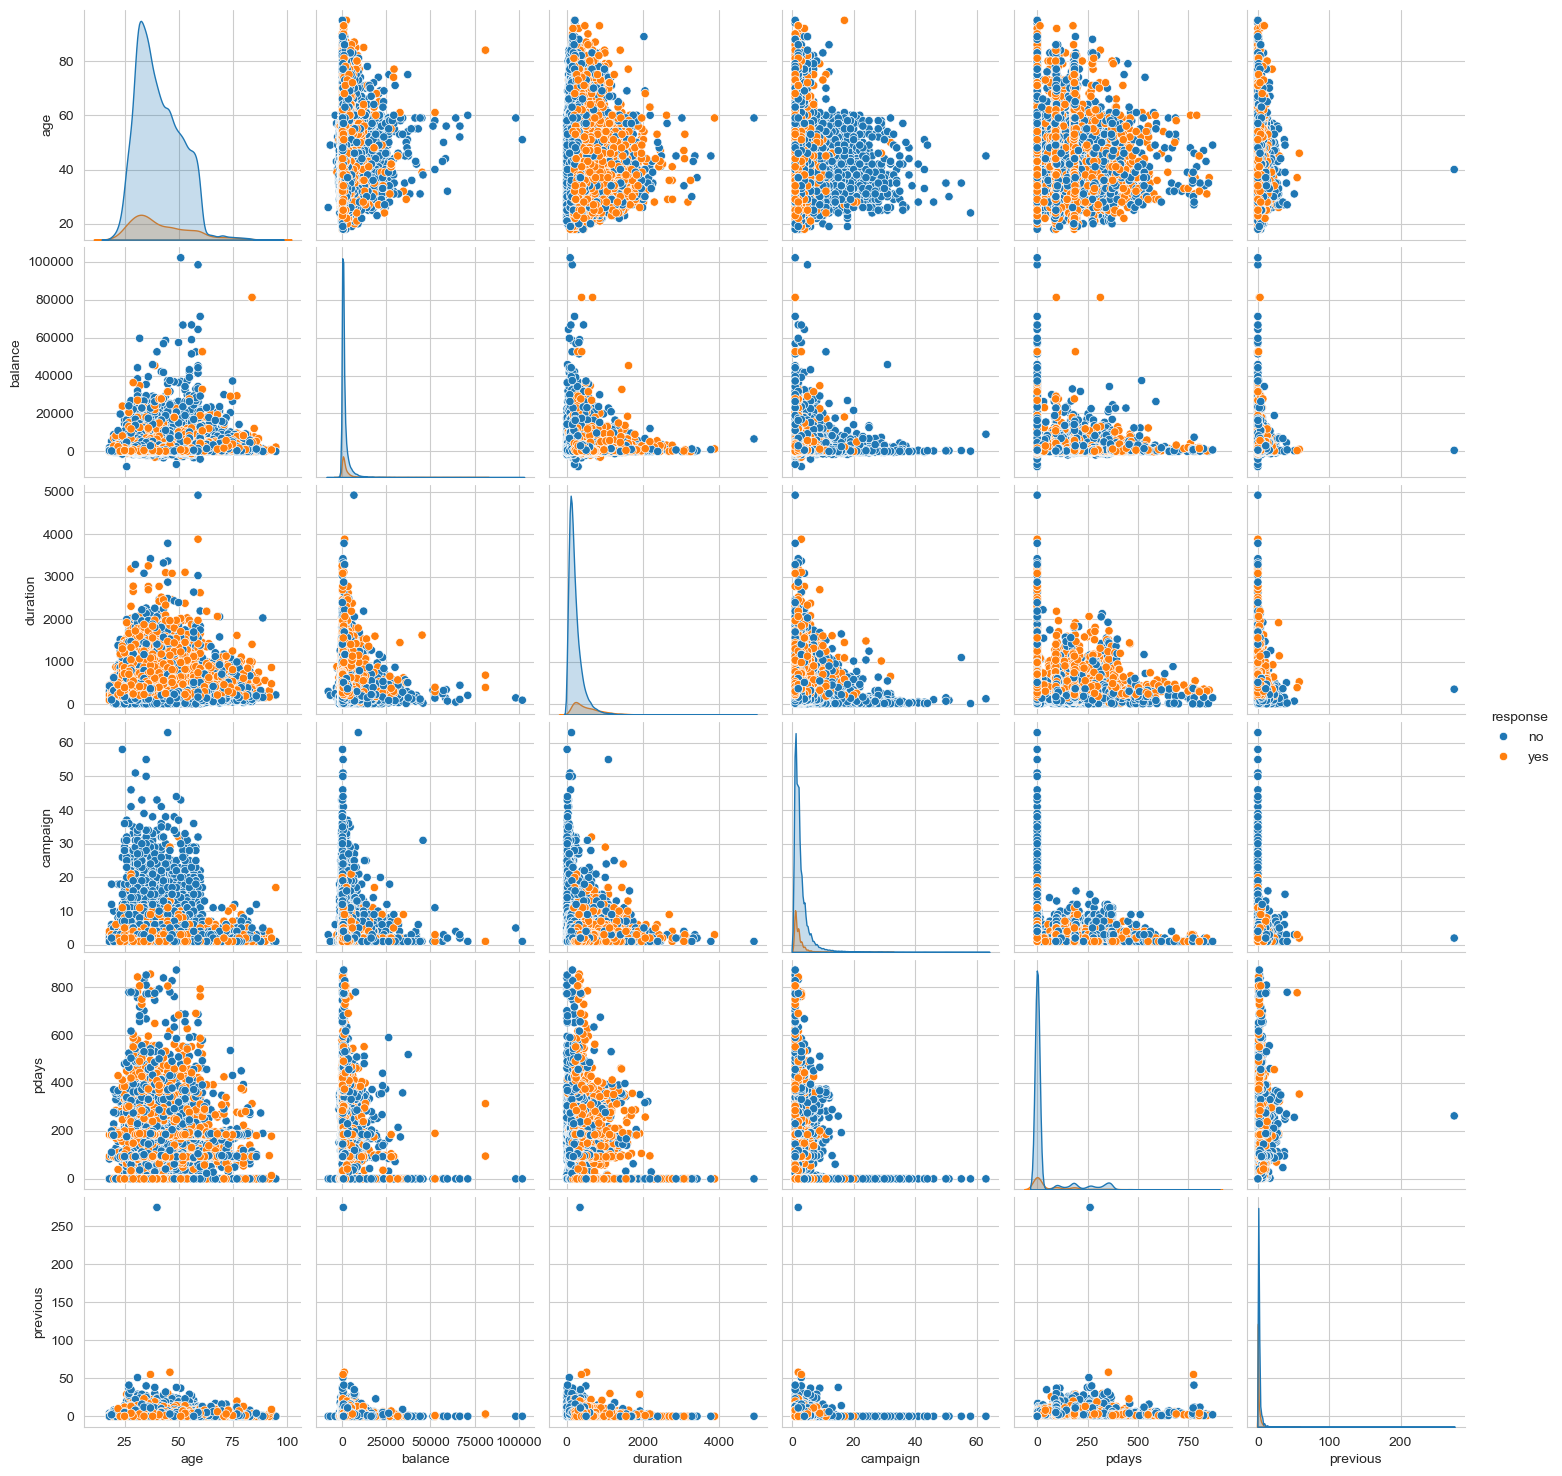

In [10]:
plt.figure(figsize=(8,12))
sns.set_style('whitegrid')
sns.pairplot(data,hue='response')
plt.show()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   job             45211 non-null  category
 2   marital_status  45211 non-null  category
 3   education       45211 non-null  category
 4   credit_default  45211 non-null  category
 5   balance         45211 non-null  int64   
 6   housing_loan    45211 non-null  category
 7   personal_loan   45211 non-null  category
 8   contact         45211 non-null  category
 9   day             45211 non-null  category
 10  month           45211 non-null  category
 11  duration        45211 non-null  int64   
 12  campaign        45211 non-null  int64   
 13  pdays           45211 non-null  int64   
 14  previous        45211 non-null  int64   
 15  response        45211 non-null  category
dtypes: category(10), int64(6)
memory usage: 2.5 MB


In [12]:
data.describe()

,age,balance,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


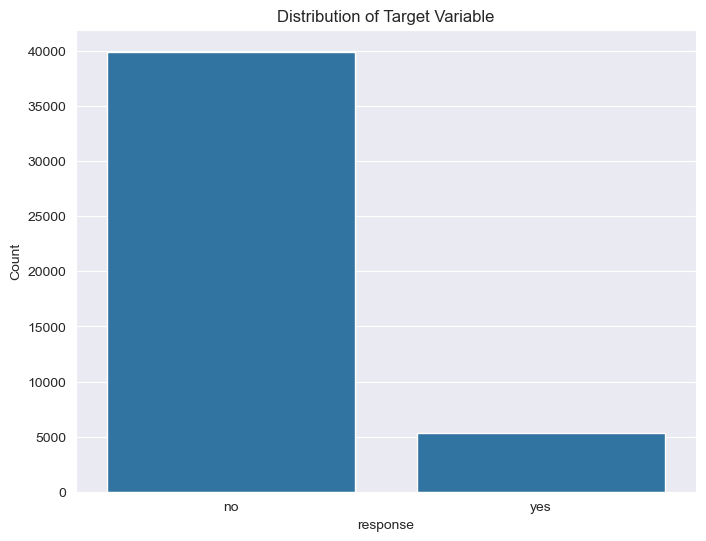

In [13]:
#Distribution plot of response variable
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.countplot(x='response', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('response')
plt.ylabel('Count')
plt.show()


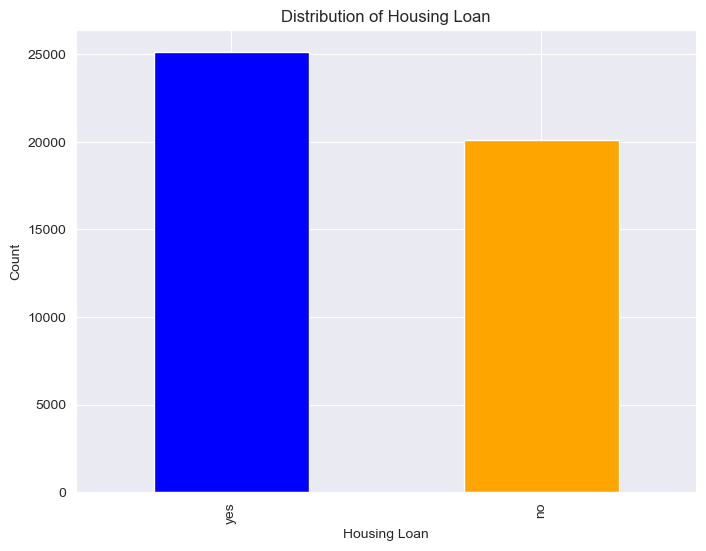

In [14]:
plt.figure(figsize=(8, 6))
data['housing_loan'].value_counts().plot(kind='bar',color=['blue', 'orange'])
plt.title('Distribution of Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.show()

<Figure size 1200x800 with 0 Axes>

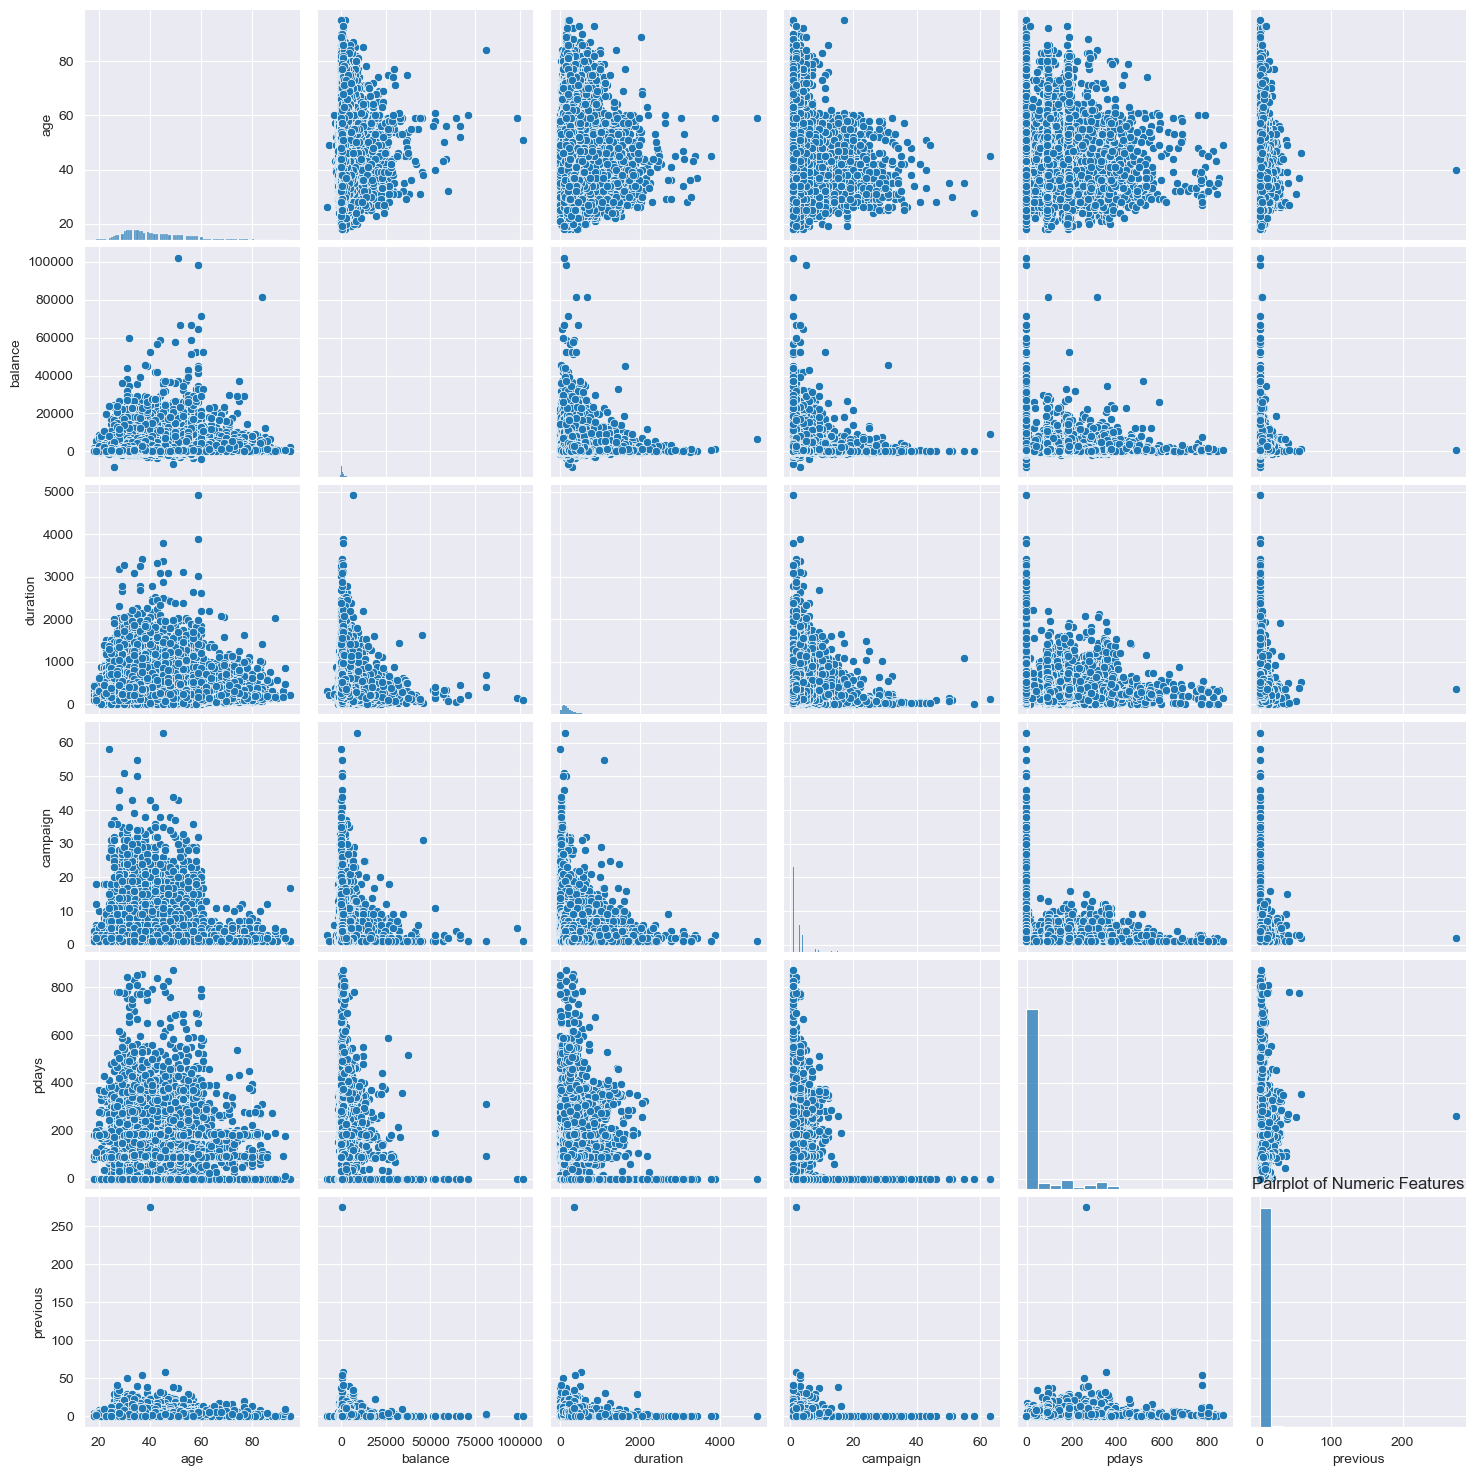

In [15]:
# Distribution plot of numeric features
plt.figure(figsize=(12, 8))
numeric_ft = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
sns.pairplot(numeric_ft)
plt.title('Pairplot of Numeric Features')
plt.show()


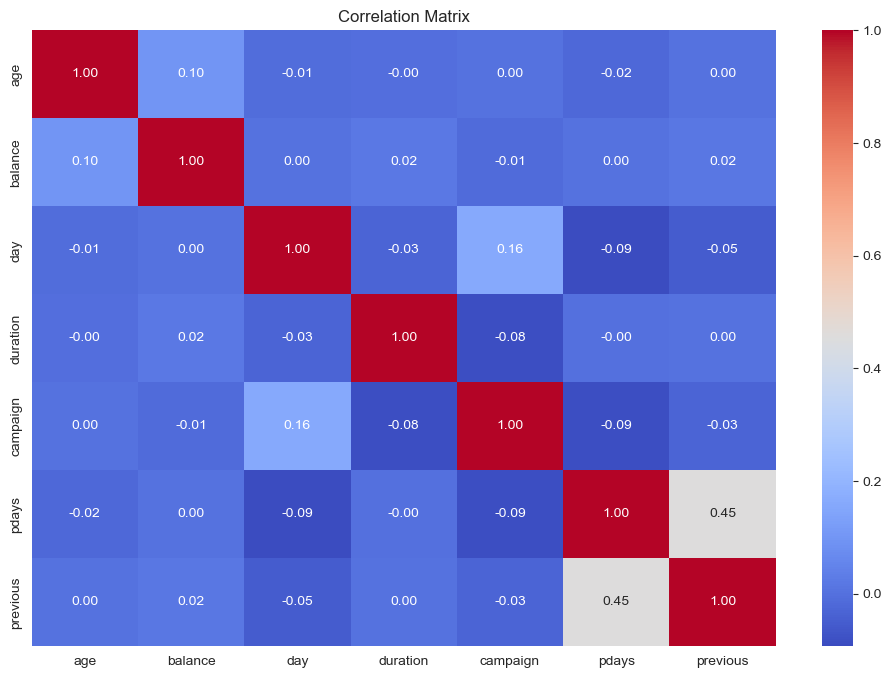

In [16]:
#Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
corr_matrix = numeric_ft.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Assign features and labels

In [17]:
X=data.drop(columns=['response'])
y=data['response']
print(X.shape)
print(y.shape)

(45211, 15)
(45211,)


Apply Preprocessing to Data

In [18]:
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan','contact','credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])

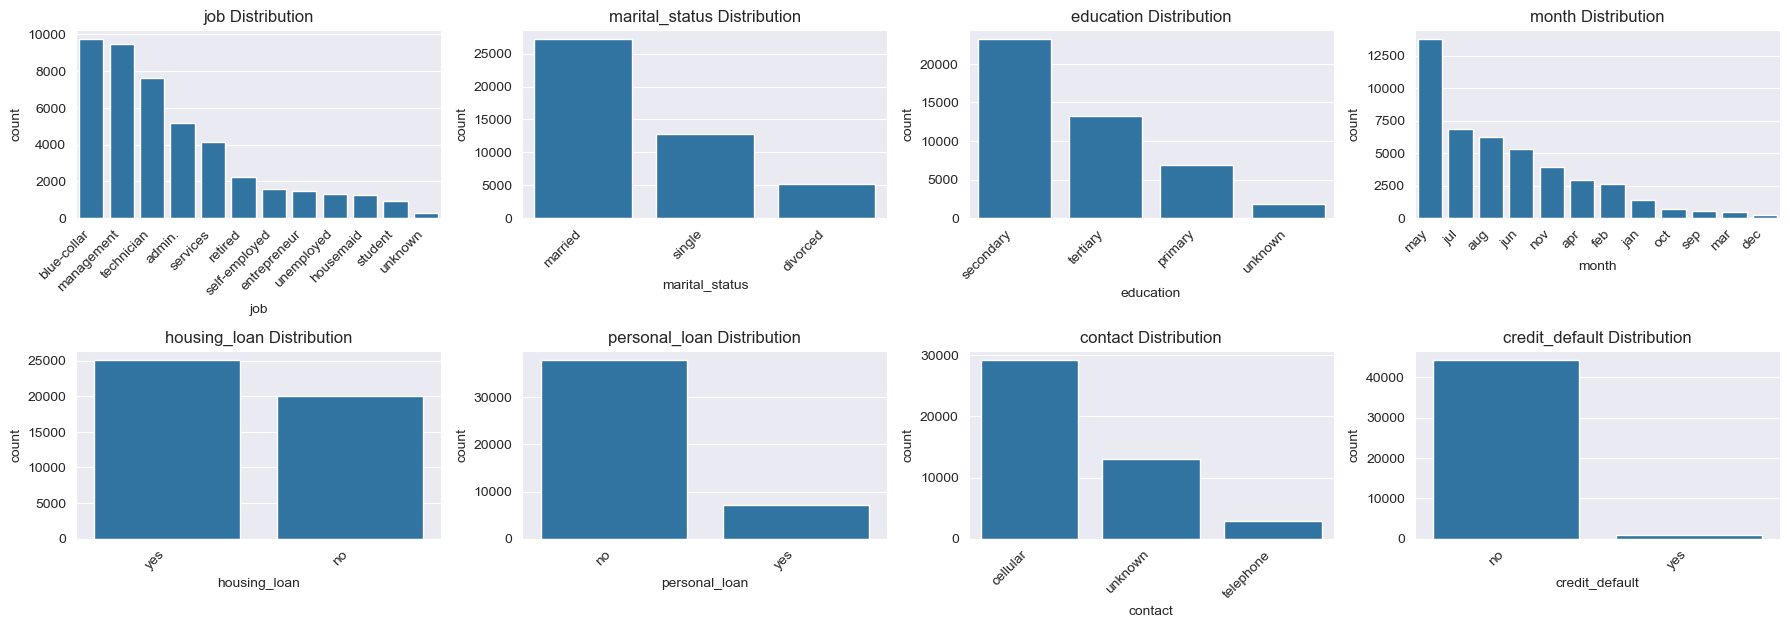

In [19]:
# Create subplots for the categorical variables
plt.figure(figsize=(18, 12))  
for i, variable in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i) 
    sns.countplot(data=data, x=variable, order=data[variable].value_counts().index)
    plt.title(f'{variable} Distribution')
    plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show() 

In [20]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

In [21]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [22]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

In [23]:
print(X_train.shape)
print(X_test.shape)


(36168, 47)
(9043, 47)


In [24]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Logistic Regression with Scikit-learn training steps

In [25]:
#Instantiate and train
logreg=LogisticRegression(class_weight= 'balanced')
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [26]:
logreg.score(X_train,y_train)

0.8381187963803739

In [27]:
logreg.score(X_test,y_test)

0.8252792214972907

Logistic Regression
Accuracy:  0.8252792214972907
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.80      0.52      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.81      0.71      9043
weighted avg       0.90      0.83      0.85      9043

Confusion Matrix: 
 [[6618 1367]
 [ 213  845]]
ROC_AUC_Score:  0.8899775453265991


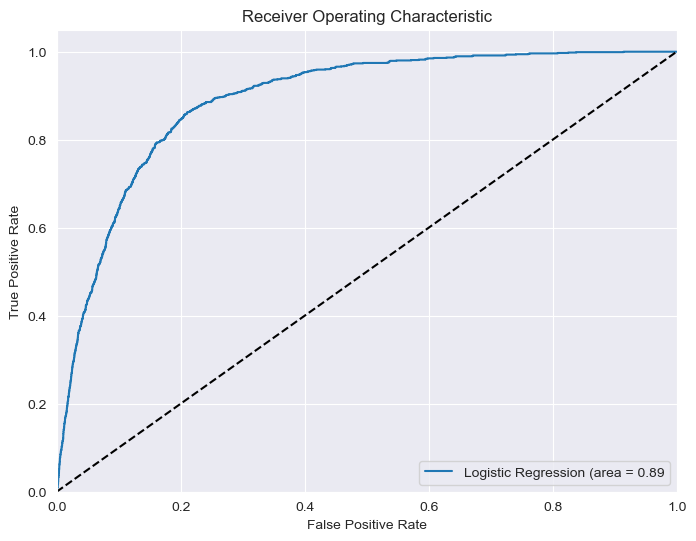

In [28]:
# Predict, Evaluate and plot
y_pred=logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
print("Logistic Regression")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC_AUC_Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Logistic Regression (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()     

Decision Tree with Scikit-learn training steps

Decision Tree Classifier
Accuracy:  0.8605551255114453
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      7985
           1       0.42      0.50      0.46      1058

    accuracy                           0.86      9043
   macro avg       0.68      0.70      0.69      9043
weighted avg       0.87      0.86      0.87      9043

Confusion Matrix: 
 [[7255  730]
 [ 531  527]]
ROC AUC Score:  0.7033441128391728


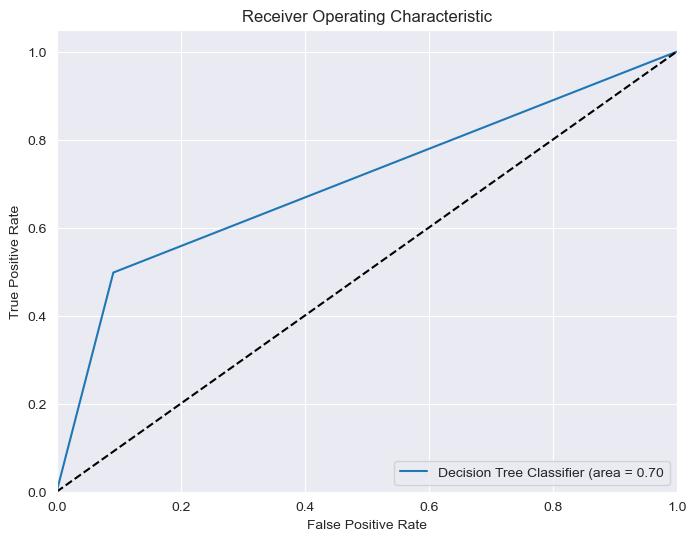

In [29]:
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)
y_pred_proba=dtree.predict_proba(X_test)[:,1]
print("Decision Tree Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Decision Tree Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Random Forest with Scikit-learn training steps

Random Forest Classifier
Accuracy:  0.8933982085591065
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.55      0.53      0.54      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.74      0.74      9043
weighted avg       0.89      0.89      0.89      9043

Confusion Matrix: 
 [[7520  465]
 [ 499  559]]
ROC AUC Score:  0.9194241802623776


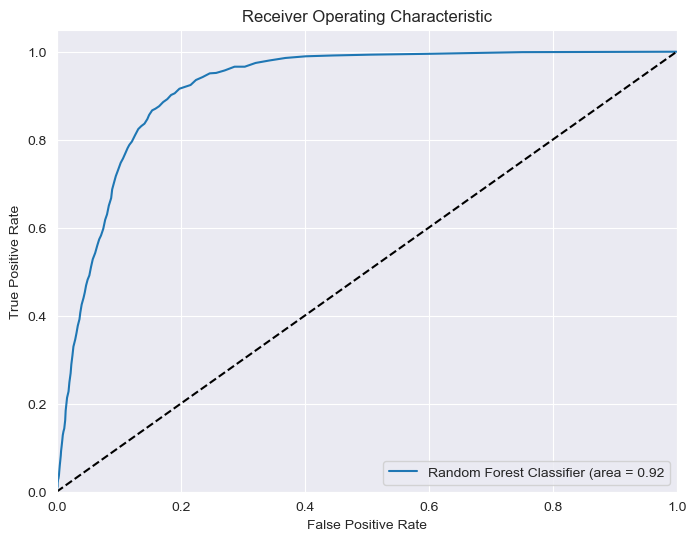

In [30]:
#Random Forest Classifier
rforest=RandomForestClassifier(class_weight= 'balanced',n_estimators=100)
rforest.fit(X_train,y_train)
y_pred=rforest.predict(X_test)
y_pred_proba=rforest.predict_proba(X_test)[:,1]
print("Random Forest Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Random Forest Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Gradient Boosting with Scikit-learn training steps

Gradient Boosting Classifier
Accuracy:  0.8724980648015039
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      7985
           1       0.47      0.73      0.57      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.81      0.75      9043
weighted avg       0.90      0.87      0.88      9043

Confusion Matrix: 
 [[7116  869]
 [ 284  774]]
ROC AUC Score:  0.9098699948982792


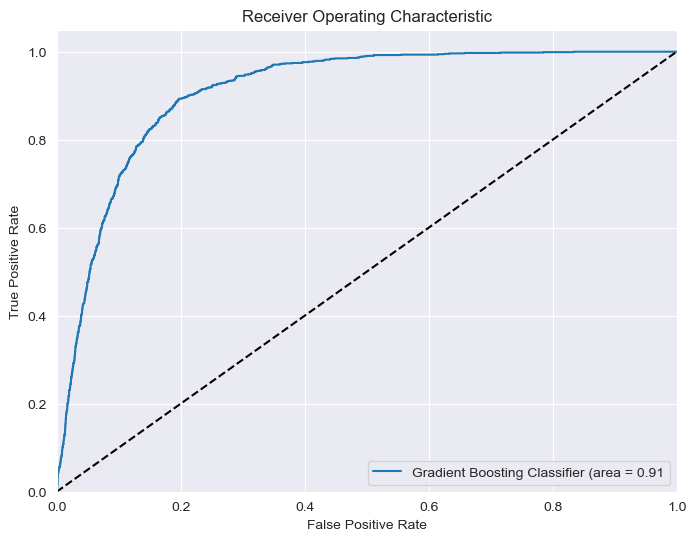

In [31]:
#Gradient Boosting Classifier
gbm=GradientBoostingClassifier()
gbm.fit(X_train,y_train)
y_pred=gbm.predict(X_test)
y_pred_proba=gbm.predict_proba(X_test)[:,1]
print("Gradient Boosting Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gradient Boosting Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

SVC with Scikit-learn training steps

In [ ]:
#Support Vector Classifier
svc=SVC(class_weight= 'balanced',probability=True)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
y_pred_proba=svc.predict_proba(X_test)[:,1]
print("Support Vector Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Support Vector Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

GaussianNB with Scikit-learn training steps

Gaussian Naive Bayes
Accuracy:  0.7391352427291827
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84      7985
           1       0.26      0.66      0.37      1058

    accuracy                           0.74      9043
   macro avg       0.60      0.70      0.60      9043
weighted avg       0.86      0.74      0.78      9043

Confusion Matrix: 
 [[5987 1998]
 [ 361  697]]
ROC AUC Score:  0.75337305415518


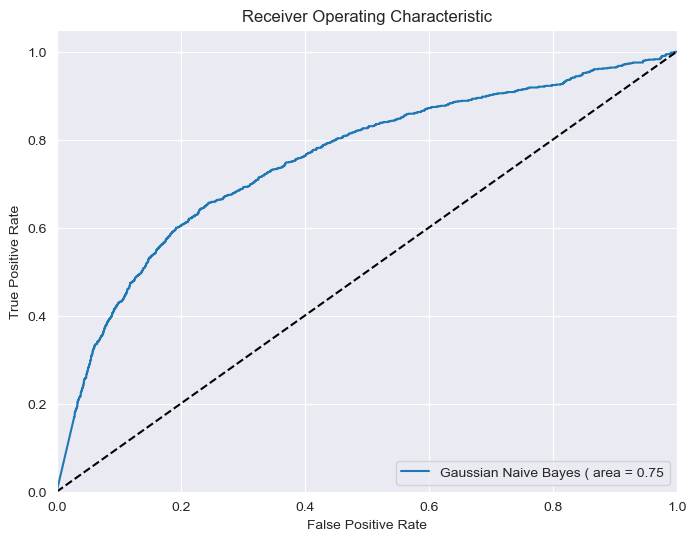

In [119]:
#Gaussian Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
y_pred_proba=gnb.predict_proba(X_test)[:,1]
print("Gaussian Naive Bayes")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gaussian Naive Bayes ( area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

KNeighbors with Scikit-learn training steps

K Neighbors Classifier
Accuracy:  0.8376644918721663
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.39      0.71      0.51      1058

    accuracy                           0.84      9043
   macro avg       0.68      0.78      0.70      9043
weighted avg       0.89      0.84      0.86      9043

Confusion Matrix: 
 [[6821 1164]
 [ 304  754]]
ROC AUC Score:  0.8453194375560036


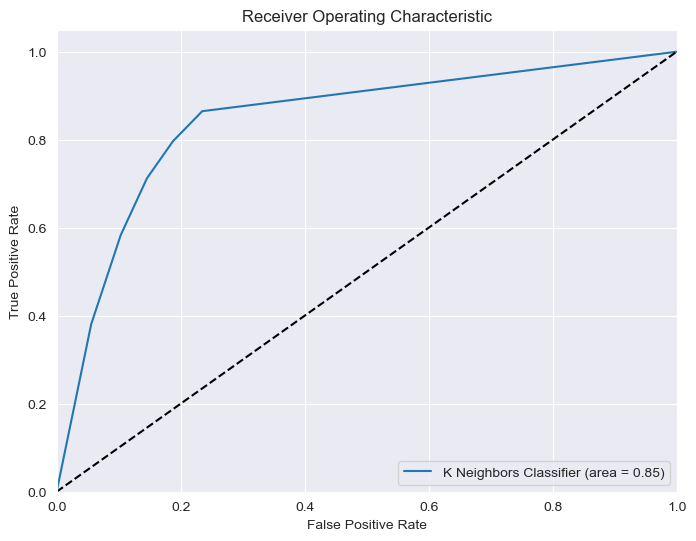

In [120]:
#K Neighbors Classifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
y_pred_proba=knn.predict_proba(X_test)[:,1]
print("K Neighbors Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='K Neighbors Classifier (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test)), 
                 accuracy_score(y_test, dtree.predict(X_test)), 
                 accuracy_score(y_test, rforest.predict(X_test)), 
                 accuracy_score(y_test, gbm.predict(X_test)), 
                 accuracy_score(y_test, svc.predict(X_test)), 
                 accuracy_score(y_test, gnb.predict(X_test)), 
                 accuracy_score(y_test, knn.predict(X_test))],
    'ROC_AUC_Score': [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, rforest.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])]
})

In [ ]:
# Sort the results by ROC_AUC_Score in descending order
results = results.sort_values(by='ROC_AUC_Score', ascending = False,ignore_index = True)
# Display the results
print(results)

In [ ]:
# Save the model
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(dtree, 'dtree_model.pkl')
joblib.dump(rforest, 'rforest_model.pkl')
joblib.dump(gbm, 'gbm_model.pkl')
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(gnb, 'gnb_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(pre_pipeline, 'pre_pipeline.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

In [ ]:
# Load the model
logreg_ = joblib.load('logreg_model.pkl')
dtree_ = joblib.load('dtree_model.pkl')
rforest_ = joblib.load('rforest_model.pkl')
gbm_ = joblib.load('gbm_model.pkl')
svc_ = joblib.load('svc_model.pkl')
gnb_ = joblib.load('gnb_model.pkl')
knn_ = joblib.load('knn_model.pkl')

In [ ]:
# Make predictions on new data
new_data = pd.DataFrame({
    'age': [30],
    'balance': [1000],
    'day': [15],
    'duration': [200],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'job': ['admin.'],
    'contact': ['cellular'],
    'marital_status': ['single'],
    'education': ['university.degree'],
    'month': ['may'],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'credit_default': ['no']
})

In [ ]:
# Preprocess the new data
new_data = pd.DataFrame(pre_processor.transform(new_data), columns=pre_processor.get_feature_names_out())
# Make predictions
logreg_pred = logreg_.predict(new_data)
dtree_pred = dtree_.predict(new_data)
rforest_pred = rforest_.predict(new_data)
gbm_pred = gbm_.predict(new_data)
svc_pred = svc_.predict(new_data)
gnb_pred = gnb_.predict(new_data)
knn_pred = knn_.predict(new_data)
# Print the predictions
print("Logistic Regression Prediction: ", logreg_pred)
print("Decision Tree Prediction: ", dtree_pred)
print("Random Forest Prediction: ", rforest_pred)
print("Gradient Boosting Prediction: ", gbm_pred)
print("SVC Prediction: ", svc_pred)
print("Gaussian Naive Bayes Prediction: ", gnb_pred)
print("K Neighbors Prediction: ", knn_pred)